### MENG 443 Final Project: Pouncing Pogo
1 legged hopping robot simulation and parameter optimization
Check bounce mechanics

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def rk4_step(f, x, u, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    # one step of runge-kutta integration, from previous hw
    k_1 = f(x, u)
    k_2 = f(x + dt*k_1/2, u)
    k_3 = f(x + dt*k_2/2, u)
    k_4 = f(x + dt*k_3, u)
    next_x = x + 1/6*dt*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return next_x

### Pogo function definitions

In [70]:
# State of pogo: [x, x_dot, y, y_dot, theta, theta_dot]
# upwards is positive

class Pogo_robot:
    def __init__(self, k, M, l0, init_x, init_xdot, init_y, init_ydot, init_theta, init_thetadot):
        """Initialize state parameters and constant"""
        self.x = init_x
        self.xdot = init_xdot
        self.y = init_y
        self.ydot = init_ydot
        self.theta = init_theta   # radian
        self.thetadot = init_thetadot
        self.k = k
        self.M = M
        self.lk = l0   # maybe check lengths, instantaneous
        self.l0 = l0   # default length
        self.ldot = 0  # initialize with no compression 
        print("Pogo initiated. Spring constant", k, ", mass", M,\
              ", leg length", l0)
        print("Initial [x, xdot, y, ydot, theta, thetadot]:", self.x, self.xdot,\
             self.y, self.ydot, self.theta, self.thetadot)
        
        # Check not initially in contact
        foot_y = self.y - self.lk*np.cos(self.theta - np.pi/2)
        if foot_y < 0:
            print("Pogo seems to be in contact already with ground, do you want to reset it?")
        else:
            print("Ready to hop!")
            print("\|/-~~~~~~~~~~")
    
    def flight(self):
        """Free flight phase (no ground contact)"""
        prev_state = np.array([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
        self.x += prev_state[1]*dT   # Euler timestep integrate
        self.xdot += 0.0
        self.y += prev_state[3]*dT
        self.ydot += -9.81*dT
        self.theta += prev_state[5]*dT
        self.thetadot += 0  # no change
        self.lk = self.l0   # back to equilibrium point
        self.ldot = 0   
        return 
  
    def is_in_contact(self):
        """
        Flag function to compute if foot lands on the 
        ground (not takeoff check)
        """ 
        foot_y = self.y - self.lk*np.cos(self.theta - np.pi/2)
        #print("Debug is_in_contact: foot_y", np.round(foot_y,3))
        if foot_y <= 0:
            print("    Incident x dot:", self.xdot)
            print("    Incident y dot:", np.round(self.ydot,3))
            return True
        else:
            return False 

    def first_contact(self):
        """
        Function with conversion of linear to rotational velocities,
        run once only per contact
        """
        #print("Debugging: contact")
        total_v = ((self.ydot)**2+(self.xdot)**2)**0.5
            
        # tangential (angular) velocity at impact
        v_tangent = -np.abs(self.ydot)*np.sin(self.theta-np.pi/2) + \
                   self.xdot*np.sin(np.pi - self.theta)
        self.thetadot = v_tangent/self.l0
        #print("    Debugging contact: theta_dot", np.round(self.thetadot,3))
        
        # radial velocity at impact
        self.ldot = -abs(self.ydot)*np.cos(self.theta-np.pi/2) - \
                    self.xdot*np.cos(np.pi - self.theta)
        #print("    Debugging contact: l_dot", np.round(self.ldot,3))
        polar_coord_speed = (v_tangent**2 + self.ldot**2)**0.5
        
        # This check is good
        #print("  Check: impact speed", total_v, "post-impact speed", polar_coord_speed)
        
        return
    
    def contact(self):
        """Contacted mechanics with the ground"""
        prev_state = np.array([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
    
        # l_ddot formula: -k/M(l_k - l_k0) - g sin(theta) + l*theta_dot^2 
        l_ddot = -self.k/self.M*(prev_state[6]-self.l0) - 9.81*np.sin(prev_state[4]) + prev_state[6]*(prev_state[5])**2
        print("    l_ddot:",np.round(l_ddot,3))
        
        # theta_ddot formula: -2*l_dot/l*theta_dot - g/l cos(theta)
        theta_ddot = -2*prev_state[7]/prev_state[6]*prev_state[5] - 9.81/prev_state[6]*np.cos(prev_state[4])
        print("    theta_ddot:",np.round(theta_ddot,3))
    
        # calculate l, theta 
        self.theta    += prev_state[5]*dT  # use previous step's accelerations
        self.thetadot += theta_ddot*dT
        self.lk       += prev_state[7]*dT
        self.ldot     += l_ddot*dT   
        
        print("    theta:", np.round(self.theta,3))
        print("    lk:", np.round(self.lk,3))
    
        # Update x, y and linear velocities, pivoting
        # TODO: check signs
        v_tan = prev_state[6]*prev_state[5]  # tangential velocity 
        self.x += prev_state[1]*dT   # Euler timestep integrate
        self.xdot = v_tan*np.cos(prev_state[4]-np.pi/2)
        self.y += prev_state[3]*dT
        self.ydot = v_tan*np.sin(prev_state[4]-np.pi/2)
    
        return
    
   
    def takeoff_check(self):
        """
        Pogo ground release check function
        Return true if spring is back to equilibrium extension 
        (to back to flight phase)
        """
        print("Current / original leg lengths:", np.round(self.lk,3), "/", np.round(self.l0,3))
        if self.lk >= self.l0:
            return True
        else:
            return False
    
    def save_state(self, array):
        """ Access and save state information to array """
        array.append([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
        return

### Pogo hops

In [75]:
dT = 0.005  # seconds, maybe just Euler integrate
state_history = []  # store trajectory

# Initialize Pogo, propagate free flight
Pogo = Pogo_robot(50,1,0.3,0, 0.2, 0.5, -0.3, 2, 0)   # Initialize k,l,m and state
test_time = 200   # total number of timesteps to simulate

time = 0
state = 0   # flag 0 - free fall; 1 - contact
while time < test_time:
    if state == 0: 
        if Pogo.is_in_contact() == False:
            Pogo.flight() 
        else:                      
            # first contact  
            print("Contacted ground at", time, "step.")
            state = 1
            Pogo.first_contact()   # compute conversion only once
            Pogo.contact()         # do compression of leg
    else:   
        # state = 1
        if Pogo.takeoff_check() == False:
            Pogo.contact()
        else:
            print("Left the ground at", time, "step.")
            state = 0
            Pogo.flight()  
    
    Pogo.save_state(state_history)
    time += 1
    
    
print(Pogo.is_in_contact())

# Check for ground contact
# 

Pogo initiated. Spring constant 50 , mass 1 , leg length 0.3
Initial [x, xdot, y, ydot, theta, thetadot]: 0 0.2 0.5 -0.3 2 0
Ready to hop!
\|/-~~~~~~~~~~
    Incident x dot: 0.2
    Incident y dot: -2.164
Contacted ground at 38 step.
    l_ddot: -7.199
    theta_ddot: -19.144
    theta: 1.988
    lk: 0.29
Current / original leg lengths: 0.29 / 0.3
    l_ddot: -6.658
    theta_ddot: -22.165
    theta: 1.976
    lk: 0.279
Current / original leg lengths: 0.279 / 0.3
    l_ddot: -6.092
    theta_ddot: -25.67
    theta: 1.963
    lk: 0.269
Current / original leg lengths: 0.269 / 0.3
    l_ddot: -5.499
    theta_ddot: -29.765
    theta: 1.949
    lk: 0.258
Current / original leg lengths: 0.258 / 0.3
    l_ddot: -4.877
    theta_ddot: -34.582
    theta: 1.935
    lk: 0.247
Current / original leg lengths: 0.247 / 0.3
    l_ddot: -4.22
    theta_ddot: -40.291
    theta: 1.919
    lk: 0.236
Current / original leg lengths: 0.236 / 0.3
    l_ddot: -3.524
    theta_ddot: -47.106
    theta: 1.903
  

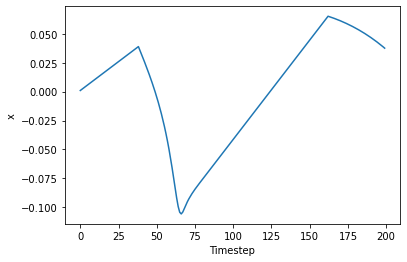

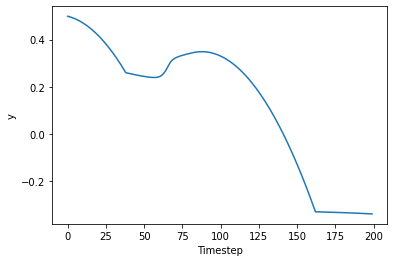

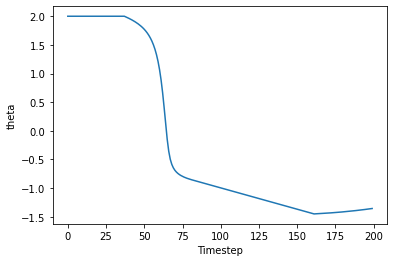

In [76]:
# Plot trajectories
x_history = []
for i in range(test_time):
    x_history.append(state_history[i][0])

plt.plot(x_history)
plt.xlabel("Timestep")
plt.ylabel("x")
plt.show()

y_history = []
for i in range(test_time):
    y_history.append(state_history[i][2])

plt.plot(y_history)
#plt.ylim(0, 0.6)
#plt.xlim(0, 40)
plt.xlabel("Timestep")
plt.ylabel("y")
plt.show()

theta_history = []
for i in range(test_time):
    theta_history.append(state_history[i][4])

plt.plot(theta_history)
plt.xlabel("Timestep")
plt.ylabel("theta")
plt.show()

